# 3<sup>η</sup> Εργασία - Ανατομία του Σθένους στο Spotify

Το παρόν αρχείο Jupyte Notebook, αποτελεί την δική μου λύση και ερμηνεία, των αποτελεσμάτων για την τρίτη εκ των τριών τελικών εργασιών του διαδικτυακού μαθήματος, “Επιστήμη Δεδομένων και Εφαρμοσμένη Μηχανική Μάθηση με Python” που προσφέρει το Mathesis.

---
> Χάκα Κέβιν <br />
> Aπόφοιτος του <br />
> Τμήματος Επιστήμης των Υλικών <br />
> Πανεπιστημίου Πατρών

> kevihaka@gmail.com

In [1]:
#Εισάγουμε τις βιβλιοθήκες που θα χρειαστούμε

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import os

In [2]:
#Διαβάζουμε τα csv αρχεία και αποθηκεύουμε τα δεδομένα σε ένα DataFrame

path = 'Charts'
df = pd.DataFrame()

for root, dirs, files in os.walk(path):
    for file in files:
        if file.split('.')[-1] == 'csv':
            df = pd.concat([df, pd.read_csv(os.path.join(root,file), sep='\t')])

before = len(df)
df.head(3)

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new


In [3]:
#Καθαρίζουμε τα δεδομένα από τις περιττές καταχωρήσεις

df.drop_duplicates(subset=['song_id'], inplace=True)
after = len(df)
df.reset_index(drop=True, inplace=True)

print(before - after)
print(round((before - after)*100/before,2), '%', sep="")
df.tail(3)

259720
94.93%


,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status
13877,162,1985nAkGJf1oOrgHCWftoN,Matrix,NLE Choppa,2100003,NaN,1,162,new
13878,184,7ntUbTIwmwOD6ygCMRZT6e,"Writing on the Wall (feat. Post Malone, Cardi ...",French Montana,1973973,NaN,1,184,new
13879,200,5BJMeoCXXgbRAWfp6fTulr,Shotta Flow (feat. Blueface) [Remix],NLE Choppa,1899350,NaN,1,200,new


Αφαιρέσαμε σχεδόν το 95% των αρχικών μας δεδομένων που αντιστοιχεί σε περίπου 259720 γραμμές και κρατήσαμε 13880 μοναδικά IDs

In [4]:
#Δημιουργούμε σύνδεση με το Spotify API
#Προσοχή από το αρχείο spotify_config.py έχουν αφαιρεθεί τα προσωπικά μου στοιχεία (client_id και client_secret)

from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'], config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [5]:
#Ρίχνουμε μια μάτια στα δεδομένα που θα λάβουμε από το API

random_id = df.song_id[0]
random_id_features = sp.audio_features(random_id)[0]
random_id_features

{'danceability': 0.681,
 'energy': 0.594,
 'key': 7,
 'loudness': -7.028,
 'mode': 1,
 'speechiness': 0.282,
 'acousticness': 0.165,
 'instrumentalness': 3.49e-06,
 'liveness': 0.134,
 'valence': 0.535,
 'tempo': 186.054,
 'type': 'audio_features',
 'id': '5aAx2yezTd8zXrkmtKl66Z',
 'uri': 'spotify:track:5aAx2yezTd8zXrkmtKl66Z',
 'track_href': 'https://api.spotify.com/v1/tracks/5aAx2yezTd8zXrkmtKl66Z',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5aAx2yezTd8zXrkmtKl66Z',
 'duration_ms': 230453,
 'time_signature': 4}

In [6]:
#Αποθηκεύουμε σε μια λίστα τα ονόματα των χαρακτηριστικών που δεν θα μας είναι χρήσιμα

useless_features = []
for key in random_id_features.keys():
    if type(random_id_features[key]) not in [int, float]:
        useless_features.append(key)
useless_features

['type', 'id', 'uri', 'track_href', 'analysis_url']

In [7]:
#Λαμβάνουμε τα χαρακτηριστικά για κάθε ID από το API

ids = df.song_id
max_ids = 100
index = 0
features = {}

while index < len(ids):
    print(f'Getting from {index} to {index+max_ids}')
    ids_batch = df.song_id[index:index+max_ids]
    features_batch = sp.audio_features(ids_batch)
    features.update({ id : id_features for id, id_features in zip(ids_batch, features_batch)})
    index += max_ids

Getting from 0 to 100
Getting from 100 to 200
Getting from 200 to 300
Getting from 300 to 400
Getting from 400 to 500
Getting from 500 to 600
Getting from 600 to 700
Getting from 700 to 800
Getting from 800 to 900
Getting from 900 to 1000
Getting from 1000 to 1100
Getting from 1100 to 1200
Getting from 1200 to 1300
Getting from 1300 to 1400
Getting from 1400 to 1500
Getting from 1500 to 1600
Getting from 1600 to 1700
Getting from 1700 to 1800
Getting from 1800 to 1900
Getting from 1900 to 2000
Getting from 2000 to 2100
Getting from 2100 to 2200
Getting from 2200 to 2300
Getting from 2300 to 2400
Getting from 2400 to 2500
Getting from 2500 to 2600
Getting from 2600 to 2700
Getting from 2700 to 2800
Getting from 2800 to 2900
Getting from 2900 to 3000
Getting from 3000 to 3100
Getting from 3100 to 3200
Getting from 3200 to 3300
Getting from 3300 to 3400
Getting from 3400 to 3500
Getting from 3500 to 3600
Getting from 3600 to 3700
Getting from 3700 to 3800
Getting from 3800 to 3900
Getting

In [8]:
#Κάνουμε έναν γρήγορο έλεγχο να δούμε αν πήραμε όσα δεδομένα περιμέναμε να πάρουμε

len(features) == len(df.song_id)

True

In [9]:
#Αποθηκεύουμε τα χαρακτηριστικά που λάβαμε σε ένα DataFrame

tracks_features = pd.DataFrame.from_dict(features, orient='index')
tracks_features.drop(useless_features, axis=1, inplace=True)
tracks_features.reset_index(names='song_id', inplace=True)
tracks_features.head(3)

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.165,0.000003,0.134,0.535,186.054,230453,4
1,5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.406,0.000000,0.180,0.742,101.965,251088,4
2,7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8,-5.599,1,0.0338,0.414,0.000000,0.111,0.661,95.010,244960,4


In [10]:
#Διαχωρίζουμε τα χαρακτηριστικά σε δυο πινάκες, τους μεταβλητές και το χαρακτηριστικό προς πρόβλεψη

column_names = list(tracks_features.columns)
column_names.remove('valence')
column_names.remove('song_id')

target = tracks_features.valence.copy()
data = tracks_features[column_names].copy()
data.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,time_signature
0,0.681,0.594,7,-7.028,1,0.2820,0.165,0.000003,0.134,186.054,230453,4
1,0.720,0.763,9,-4.068,0,0.0523,0.406,0.000000,0.180,101.965,251088,4
2,0.748,0.524,8,-5.599,1,0.0338,0.414,0.000000,0.111,95.010,244960,4


In [11]:
#Διαβάζουμε και αποθηκεύουμε τα ID που πρόκειται να προβλέψουμε το σθένος, μετά την εκπαίδευση των μοντέλων σε ένα DataFrame

spotify_ids = pd.read_csv("spotify_ids.txt", names=['song_id'])
spotify_ids.head(3)

,song_id
0,7lPN2DXiMsVn7XUKtOW1CS
1,5QO79kh1waicV47BqGRL3g
2,0VjIjW4GlUZAMYd2vXMi3b


In [12]:
#Λαμβάνουμε τα χαρακτηριστικά για κάθε ID από το API

max_ids = 100
index = 0
features = {}

while index < len(spotify_ids):
    print(f'Getting from {index} to {index+max_ids}')
    ids_batch = spotify_ids.song_id[index:index+max_ids]
    features_batch = sp.audio_features(ids_batch)
    features.update({ id : id_features for id, id_features in zip(ids_batch, features_batch)})
    index += max_ids

Getting from 0 to 100
Getting from 100 to 200
Getting from 200 to 300
Getting from 300 to 400
Getting from 400 to 500
Getting from 500 to 600
Getting from 600 to 700
Getting from 700 to 800
Getting from 800 to 900
Getting from 900 to 1000
Getting from 1000 to 1100
Getting from 1100 to 1200


In [13]:
#Κάνουμε και πάλι έναν γρήγορο έλεγχο

len(features) == len(spotify_ids)

True

In [14]:
#Αποθηκεύουμε τα χαρακτηριστικά που λάβαμε σε ένα DataFrame

tracks_features_p = pd.DataFrame.from_dict(features, orient='index')
tracks_features_p.drop(useless_features, axis=1, inplace=True)
tracks_features_p.reset_index(names='song_id', inplace=True)
tracks_features_p.tail(3)

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
1159,3E3pb3qH11iny6TFDJvsg5,0.754,0.660,0,-6.811,1,0.267,0.1790,0.00000,0.1940,0.316,83.000,209299,4
1160,3yTkoTuiKRGL2VAlQd7xsC,0.584,0.836,0,-4.925,1,0.079,0.0558,0.00000,0.0663,0.484,104.973,202204,4
1161,4JE6agBLHGA5TaF6FlqfBD,0.331,0.450,10,-5.362,1,0.034,0.3650,0.00464,0.2200,0.180,123.829,218755,4


In [15]:
#Διαχωρίζουμε τα χαρακτηριστικά και πάλι σε δυο πινάκες, τους μεταβλητές και το χαρακτηριστικό προς πρόβλεψη

target_p = tracks_features_p.valence.copy()
data_p = tracks_features_p[column_names].copy()
data_p.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,time_signature
0,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,143.874,242014,4
1,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,118.051,215627,4
2,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,171.005,200040,4


In [16]:
#Πρώτο μοντέλο - ExtraTreesRegressor
#Κατασκευάζουμε πλέγμα παραμέτρων και τρέχουμε το μοντέλο για να βρούμε τις καλύτερες παραμέτρους

model_1_param_grid = {
    'extratreesregressor__max_depth' : [5, 6, None],
    'extratreesregressor__min_samples_split' : [2, 3, 4],
    'extratreesregressor__min_samples_leaf' : [1, 10, 100],
    'extratreesregressor__max_features' : ['sqrt', 'log2', None]
}

model_1 = make_pipeline(StandardScaler(), ExtraTreesRegressor())
model_1_grid_search = GridSearchCV(model_1, param_grid=model_1_param_grid, cv=KFold(n_splits=10 ,shuffle=True), 
                           scoring='neg_mean_absolute_error', n_jobs=-1)
model_1_grid_search.fit(data, target)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('extratreesregressor',
                                        ExtraTreesRegressor())]),
             n_jobs=-1,
             param_grid={'extratreesregressor__max_depth': [5, 6, None],
                         'extratreesregressor__max_features': ['sqrt', 'log2',
                                                               None],
                         'extratreesregressor__min_samples_leaf': [1, 10, 100],
                         'extratreesregressor__min_samples_split': [2, 3, 4]},
             scoring='neg_mean_absolute_error')

In [17]:
#Στοιχίζουμε τους εκτιμητές βάση απόδοσης

model_1_grid_search_results = pd.DataFrame(model_1_grid_search.cv_results_)
model_1_grid_search_results.sort_values(by='rank_test_score').head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_extratreesregressor__max_depth,param_extratreesregressor__max_features,param_extratreesregressor__min_samples_leaf,param_extratreesregressor__min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
72,38.787954,0.590092,0.112190,0.002540,None,None,1,2,"{'extratreesregressor__max_depth': None, 'extr...",-0.124250,...,-0.122634,-0.121143,-0.118142,-0.124587,-0.123475,-0.122682,-0.118925,-0.120811,0.003146,1
54,12.539506,0.202705,0.117092,0.009296,None,sqrt,1,2,"{'extratreesregressor__max_depth': None, 'extr...",-0.124772,...,-0.122841,-0.121408,-0.117834,-0.124001,-0.124318,-0.124302,-0.119282,-0.121267,0.003178,2
63,14.745131,0.209612,0.125250,0.003826,None,log2,1,2,"{'extratreesregressor__max_depth': None, 'extr...",-0.125190,...,-0.123740,-0.121896,-0.118346,-0.124019,-0.124382,-0.123366,-0.118515,-0.121394,0.003170,3
73,30.300360,0.287951,0.113903,0.008229,None,None,1,3,"{'extratreesregressor__max_depth': None, 'extr...",-0.125560,...,-0.123394,-0.121627,-0.119291,-0.125191,-0.125764,-0.123925,-0.119449,-0.121671,0.003565,4


Επειδή ο αλγόριθμος ExtraTreesRegressor είναι στοχαστικός το πιθανότερο είναι η σειρά των αποτελεσμάτων να αλλάξει ελαφρώς κάθε φορά που το τρέχουμε, και αυτό γιατί η αποδόσεις στα πρώτα τουλάχιστον είναι παρόμοιες. Με δεδομένο αυτό θα επιλέξω τις default παραμέτρους εκτός από το max_features όπου θα το αλλάξω, χωρίς κάποιο ιδιαίτερο λόγο σε **sqrt**.

In [18]:
#Εκπαιδεύουμε το μοντέλο με όλα τα δεδομένα

model_1 = make_pipeline(StandardScaler(), ExtraTreesRegressor(max_features='sqrt'))
model_1.fit(data, target)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('extratreesregressor',
                 ExtraTreesRegressor(max_features='sqrt'))])

In [19]:
#Δεύτερο μοντέλο - SGDRegressor
#Κατασκευάζουμε πλέγμα παραμέτρων και τρέχουμε το μοντέλο για να βρούμε τις καλύτερες παραμέτρους

model_2_param_grid = {
    'sgdregressor__penalty' : ['l2', 'l1', None],
    'sgdregressor__alpha' : [0.0001, 0.001, 0.01, 0.1],
    'sgdregressor__learning_rate' : ['constant', 'optimal', 'invscaling'],
    'sgdregressor__eta0' : [0.01, 0.1, 1.0],
    'sgdregressor__power_t' : [0.1, 0.25, 0.4, 0.55, 0.7, 0.85, 1.0]
}

model_2 = make_pipeline(StandardScaler(), SGDRegressor())
model_2_grid_search = GridSearchCV(model_2, param_grid=model_2_param_grid, cv=KFold(n_splits=10 ,shuffle=True), 
                           scoring='neg_mean_absolute_error', n_jobs=-1)
model_2_grid_search.fit(data, target)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdregressor', SGDRegressor())]),
             n_jobs=-1,
             param_grid={'sgdregressor__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'sgdregressor__eta0': [0.01, 0.1, 1.0],
                         'sgdregressor__learning_rate': ['constant', 'optimal',
                                                         'invscaling'],
                         'sgdregressor__penalty': ['l2', 'l1', None],
                         'sgdregressor__power_t': [0.1, 0.25, 0.4, 0.55, 0.7,
                                                   0.85, 1.0]},
             scoring='neg_mean_absolute_error')

In [20]:
#Στοιχίζουμε τους εκτιμητές βάση απόδοσης

model_2_grid_search_results = pd.DataFrame(model_2_grid_search.cv_results_)
model_2_grid_search_results.sort_values(by='rank_test_score').head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdregressor__alpha,param_sgdregressor__eta0,param_sgdregressor__learning_rate,param_sgdregressor__penalty,param_sgdregressor__power_t,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
186,0.077839,0.010591,0.009783,0.008633,0.0001,1.0,invscaling,None,0.7,"{'sgdregressor__alpha': 0.0001, 'sgdregressor_...",...,-0.153496,-0.153754,-0.153397,-0.153488,-0.155628,-0.150852,-0.150855,-0.152988,0.001350,1
297,0.076166,0.016218,0.015134,0.022123,0.001,0.1,invscaling,l2,0.55,"{'sgdregressor__alpha': 0.001, 'sgdregressor__...",...,-0.153301,-0.153679,-0.153195,-0.153854,-0.155401,-0.150985,-0.151327,-0.153009,0.001222,2
625,0.075333,0.005764,0.007516,0.006664,0.1,0.01,invscaling,None,0.4,"{'sgdregressor__alpha': 0.1, 'sgdregressor__et...",...,-0.153216,-0.153765,-0.153473,-0.153872,-0.155468,-0.150806,-0.151120,-0.153010,0.001291,3
179,0.095267,0.006390,0.005355,0.006149,0.0001,1.0,invscaling,l1,0.7,"{'sgdregressor__alpha': 0.0001, 'sgdregressor_...",...,-0.153218,-0.153445,-0.153868,-0.154087,-0.155493,-0.150907,-0.151048,-0.153012,0.001311,4


Όπως και με το προηγούμενο μοντέλο έτσι και εδώ η σειρά των αποτελεσμάτων λόγο τυχαιότητας ενδέχεται να αλλάζει ελαφρώς, αυτό γιατί οι τιμές των αποδόσεων στα πρώτα τουλάχιστον αποτελέσματα του πινάκα είναι παρόμοια και η σειρά κατάταξης τους επηρεάζεται από την διακύμανση. Δεδομένο των παραπάνω λεχθέντων θα επιλέξουμε όπως και πριν τις default παραμέτρους εκτός της παραμέτρου power_t την οποία θα την ορίσουμε στο **0.55**.

In [21]:
#Εκπαιδεύουμε το μοντέλο με όλα τα δεδομένα

model_2 = make_pipeline(StandardScaler(), SGDRegressor(power_t = 0.55))
model_2.fit(data, target)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(power_t=0.55))])

In [22]:
#Τρίτο μοντέλο - SVR
#Κατασκευάζουμε πλέγμα παραμέτρων και τρέχουμε το μοντέλο για να βρούμε τις καλύτερες παραμέτρους

model_3_param_grid = {
    'svr__kernel': ["linear", "rbf", "poly"],
    'svr__C' : [0.1, 1],
    'svr__epsilon' : [0.01, 0.1, 1]
}
        
model_3 = make_pipeline(StandardScaler(), SVR())
model_3_grid_search = GridSearchCV(model_3, param_grid=model_3_param_grid, cv=KFold(n_splits=10 ,shuffle=True), 
                           scoring='neg_mean_absolute_error', n_jobs=-1)
model_3_grid_search.fit(data, target)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1], 'svr__epsilon': [0.01, 0.1, 1],
                         'svr__kernel': ['linear', 'rbf', 'poly']},
             scoring='neg_mean_absolute_error')

In [23]:
#Στοιχίζουμε τους εκτιμητές βάση απόδοσης

model_3_grid_search_results = pd.DataFrame(model_3_grid_search.cv_results_)
model_3_grid_search_results.sort_values(by='rank_test_score').head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,param_svr__kernel,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
10,48.349603,1.295349,9.335255,0.763119,1,0.01,rbf,"{'svr__C': 1, 'svr__epsilon': 0.01, 'svr__kern...",-0.143006,-0.146746,...,-0.146680,-0.137629,-0.146666,-0.146191,-0.140814,-0.143607,-0.148259,-0.144433,0.003087,1
1,32.115180,0.468516,8.989613,0.700736,0.1,0.01,rbf,"{'svr__C': 0.1, 'svr__epsilon': 0.01, 'svr__ke...",-0.146889,-0.147681,...,-0.146313,-0.139659,-0.148177,-0.146862,-0.139755,-0.144223,-0.147602,-0.145232,0.002982,2
13,30.021587,1.117813,5.882549,0.996709,1,0.1,rbf,"{'svr__C': 1, 'svr__epsilon': 0.1, 'svr__kerne...",-0.145643,-0.147896,...,-0.147080,-0.139140,-0.148121,-0.147150,-0.142906,-0.144328,-0.147573,-0.145434,0.002677,3
4,20.917952,0.617320,6.159341,0.097037,0.1,0.1,rbf,"{'svr__C': 0.1, 'svr__epsilon': 0.1, 'svr__ker...",-0.147387,-0.148499,...,-0.146846,-0.141003,-0.149678,-0.147406,-0.140635,-0.144958,-0.147329,-0.145935,0.002848,4


Παρατηρούμε πως τις καλύτερες επιδόσεις το παραπάνω μοντέλο τις έχει με την εκθετική συνάρτηση, αυτό μας ερμηνεύει κατά κάποιον τρόπο γιατί το ExtraTreesRegressor είχε καλύτερη επίδοση σε σχέση με το SGDRegressor, ο λόγος φαίνεται να είναι ότι τα δεδομένα μας δεν είναι τόσο καλά ερμηνεύσιμα γραμμικά. Για παραμέτρους θα χρησιμοποιήσουμε τις default.

In [24]:
#Εκπαιδεύουμε το μοντέλο με όλα τα δεδομένα

model_3 = make_pipeline(StandardScaler(), SVR())
model_3.fit(data, target)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

Παρακάτω θα δούμε μια εκτίμηση για το πόσο σημαντική θεωρεί το κάθε μοντέλο την κάθε μεταβλητή, θα χρησιμοποιήσουμε την μέθοδο permutation_importance του module inspection της sklearn, αυτό θα το κάνουμε γιατί πρώτον, δεν έχουν όλα τα μοντέλα μας εσωτερικές μεθόδους ή ιδιότητες για την εξαγωγή αυτής η σχετικής πληροφορίας, και δεύτερων, για να έχουμε μια κοινή βάση στις παρατηρήσεις μας.

In [25]:
#Ορίζουμε δυο συναρτήσεις, μια για των υπολογισμό των σημαντικοτήτων των μεταβλητών και μια για την απεικόνιση τους

X_train, X_test, y_train, y_test = train_test_split(data, target)

def feature_importances_calculation(estimator, X_train, X_test, y_train, y_test, scoring='neg_mean_absolute_error'):
    model = make_pipeline(StandardScaler(), estimator).fit(X_train, y_train)
    return permutation_importance(model, X_test, y_test, n_repeats=10, n_jobs=-1, scoring=scoring)
    
def plot_feature_importances(importances, indices, subtitle=None, color='r'):
    plt.figure(figsize=(10, 5))
    plt.title(f"Feature importances {subtitle}")
    plt.bar(range(len(data.columns)), importances[indices], 
            tick_label=[data.columns[x] for x in indices], color=color, align="center")
    plt.grid()
    _ = plt.xticks(rotation=45)

In [26]:
#Υπολογίζουμε τις σημαντικότητες των μεταβλητών

r1 = feature_importances_calculation(ExtraTreesRegressor(max_features='sqrt'), 
                                    X_train, X_test, y_train, y_test)

r2 = feature_importances_calculation(SGDRegressor(power_t = 0.55), 
                                     X_train, X_test, y_train, y_test)
    
r3 = feature_importances_calculation(SVR(), 
                                     X_train, X_test, y_train, y_test)

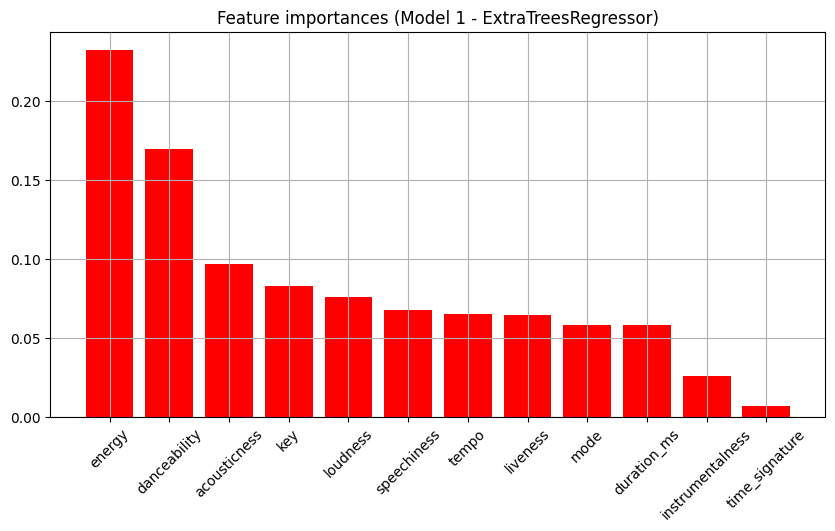

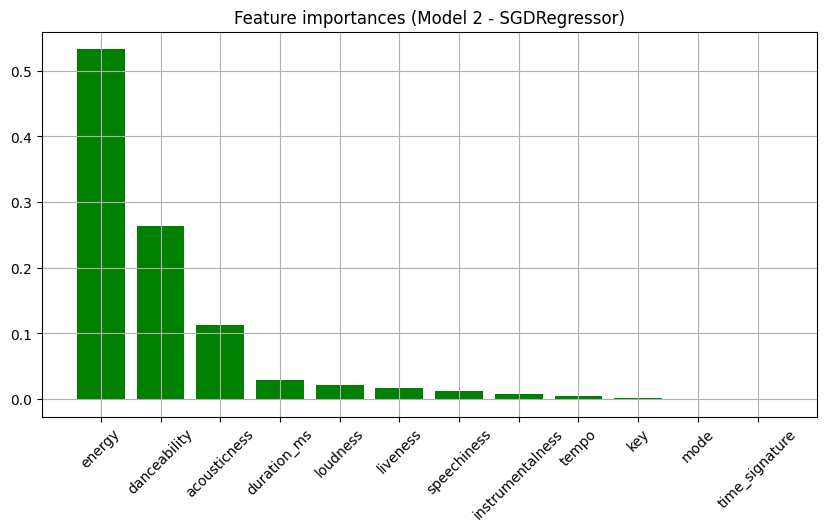

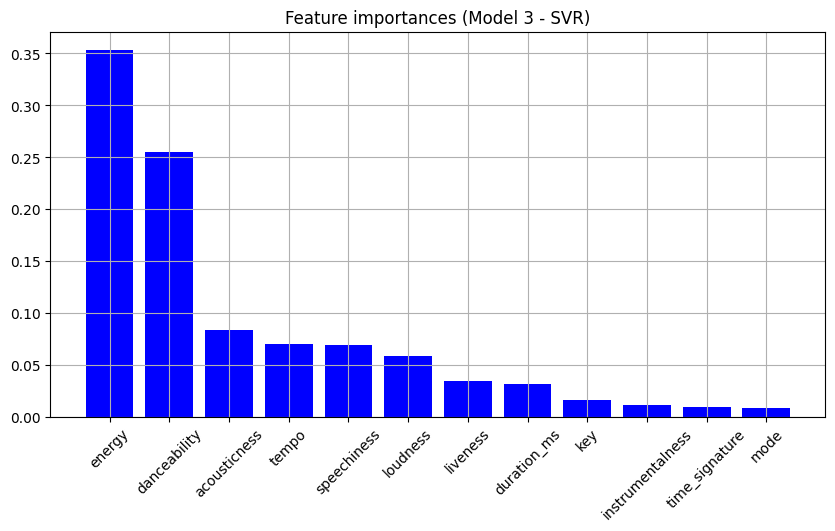

In [27]:
#Απεικονίζουμε τις σημαντικότητες των μεταβλητών

plot_feature_importances(r1.importances_mean/sum(r1.importances_mean), r1.importances_mean.argsort()[::-1],
                         '(Model 1 - ExtraTreesRegressor)', 'r')
plot_feature_importances(r2.importances_mean/sum(r2.importances_mean), r2.importances_mean.argsort()[::-1], 
                         '(Model 2 - SGDRegressor)', 'g')
plot_feature_importances(r3.importances_mean/sum(r3.importances_mean), r3.importances_mean.argsort()[::-1], 
                         '(Model 3 - SVR)', 'b')

Στα διαγράμματα παρατηρούμε κάτι κοινό, και στα τρία μοντέλα οι τρις μεταβλητές που επηρεάζουν περισσότερο το αποτέλεσμα είναι τα energy, danceability, acousticness με αυτή την σειρά αλλά με άλλη σημαντικότητα στο καθένα. Επίσης κοινό είναι και το γεγονός πως και στα τρία η μεταβλητής time_signature παίζει από ελάχιστο έως και μηδαμινό ρόλο. Αξιοσημείωτο είναι το γεγονός πως το δεύτερο μοντέλο (το οποίο είχε και την μικρότερη απόδοση) εκμεταλλεύεται τις υπόλοιπες μεταβλητές εκτός από τις τρις πρώτες που αναφέραμε από ελάχιστα έως και καθόλου, ενώ αντίθετα, το πρώτο μοντέλο (το οποίο είχε και την καλύτερη απόδοση) έχει μια πιο εξισορροπημένη χρήση των μεταβλητών, τέλος, το τρίτο μοντέλο βρίσκεται κάπου ενδιάμεσα και στην χρήση των μεταβλητών άλλα και στη απόδοση. Το συμπέρασμα που βγαίνει από τα παραπάνω λεχθέντα χωρείς παρ' όλ' αυτά να αποτελεί απόδειξη η κανόνα, είναι πως η σωστή και ζυγισμένη εκμετάλλευση των μεταβλητών από το εκάστοτε μοντέλο φέρνει καλύτερα αποτελέσματα από ένα μοντέλο το οποίο υπερεκτιμά μερικούς μεταβλητές και τις υπόλοιπες τις θεωρεί θορυβώ. Προφανώς, αυτό είναι δίκοπο μαχαίρι, αφού η χρήση μιας μεταβλητής που είναι όντως θόρυβος, δηλαδή δεν υπάρχει πραγματική σχέση ανάμεσα στην μεταβλητή και την μετρούμενη ποσότητα μπορεί να υποβιβάσει το μοντέλο μας και να μειώσει την απόδοση του. Η συμπερίληψη μιας μεταβλητής στο μοντέλο θα πρέπει να είναι πρώτιστος δικιά μας ευθύνη βασισμένη στις γνώσεις μας για το αν μπορεί να υπάρχει κάποια συσχέτιση με την μετρούμενη ποσότητα.

In [28]:
#Υπολογισμός του μέσου απόλυτου λάθους του κάθε μοντέλου για πρόβλεψη του σθένους των κομματιών στο αρχείο spotify_ids.txt

mae1 = mean_absolute_error(target_p, model_1.predict(data_p))
mae2 = mean_absolute_error(target_p, model_2.predict(data_p))
mae3 = mean_absolute_error(target_p, model_3.predict(data_p))

print('{:<19} {}'.format('ExtraTreesRegressor', round(mae1,3)))
print('{:<19} {}'.format('SGDRegressor', round(mae2,3)))
print('{:<19} {}'.format('SVR', round(mae3,3)))

ExtraTreesRegressor 0.137
SGDRegressor        0.162
SVR                 0.149


### Συνεχίζουμε με την κατασκευή ενός μοντέλου νευρωνικών δικτύων

In [29]:
#Κατασκευάζουμε μια συνάρτηση για να μας φτιάχνει διάγραμμα απωλειών με το χρόνο 
#και μια κλάση η οποία μας βελτιώνει την εμφάνιση κατά την εκπαίδευση του μοντέλου

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
class EpochDots(tf.keras.callbacks.Callback):
    """A simple callback that prints a "." every epoch, with occasional reports.
    
    Args:
        report_every: How many epochs between full reports
        dot_every: How many epochs between dots.
    """

    def __init__(self, report_every=100, dot_every=1):
        self.report_every = report_every
        self.dot_every = dot_every

    def on_epoch_end(self, epoch, logs):
        if epoch % self.report_every == 0:
            print()
            print('Epoch: {:d}, '.format(epoch), end='')
            for name, value in sorted(logs.items()):
                print('{}:{:0.4f}'.format(name, value), end=',  ')
            print()

        if epoch % self.dot_every == 0:
            print('.', end='', flush=True)

In [30]:
#Ρυθμίζουμε μερικές παραμέτρου που θα μας χρειαστούν 

num_epochs = 1000
group_epochs = 20
batch_size = 100
steps_per_epoch = len(data) // batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=steps_per_epoch * group_epochs,
  decay_rate=1,
  staircase=False)

In [31]:
#Δημιουργούμε ένα στρώμα κανονικοποίησης

normalizer = layers.Normalization()
normalizer.adapt(data)

In [32]:
#Κατασκευάζουμε το μοντέλο μας

model = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dropout(.3),
        layers.Dense(1)
    ])

model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(lr_schedule))

In [33]:
#Ρίχνουμε μια ματιά στις παραμέτρους μας

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 12)                25        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                832       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 922 (3.61 KB)
Trainable params: 897 (3.50 KB)
Non-trainable params: 25 (104.00 Byte)
_________________________________________________________________


Έχει αρκετές παραμέτρους προς εκπαίδευση αλλά όχι τόσες ώστε να ανησυχούμε για overfitting, παρ' όλ' αυτά εμείς έχουμε τοποθετήσει και μια στρώση dropout που θα μεριμνήσει και γι' αυτό αλλά κυρίως θέλαμε να εισάγουμε λίγη τυχαιότητα.

In [34]:
#Εκπαιδεύουμε το μοντέλο με μηχανισμό σύγκλησης

early_stop = [
    EpochDots(group_epochs),
    tf.keras.callbacks.EarlyStopping(patience=group_epochs)]


history = model.fit(
    data, 
    target,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=0,
    callbacks=early_stop)


Epoch: 0, loss:0.3426,  val_loss:0.1762,  
....................
Epoch: 20, loss:0.1498,  val_loss:0.1511,  
..................

Deep learning 0.155


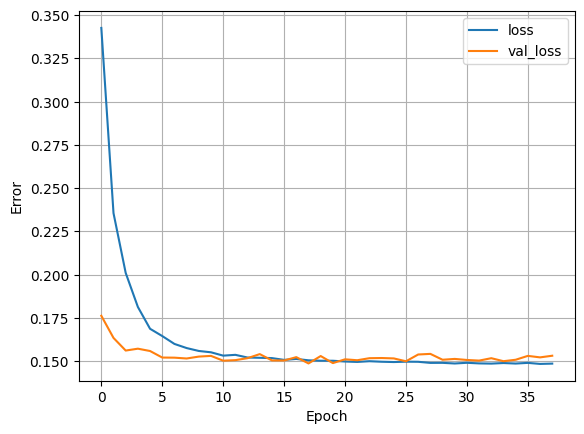

In [35]:
#Τα αποτελέσματα

plot_loss(history)
mae = model.evaluate(data_p, target_p, verbose=0)
print('Deep learning', round(mae,3))

Για να είμαι ειλικρινής περίμενα από την βαθιά εκμάθηση να έχει το καλύτερο αποτέλεσμα και ίσως και με διάφορα από τα υπόλοιπα, άλλα δυστυχώς όσο και να προσπάθησα δεν τα κατάφερα. Προφανώς και οι δυνατότητες της βαθιάς εκμάθησης είναι πάρα πολλές και είμαι σίγουρος πως μπορεί να πετύχει πολύ καλύτερο αποτέλεσμα με καλύτερες αρχιτεκτονικές και βελτιστοποίηση των παραμέτρων άλλα δυστυχώς αυτό απαιτεί να αφιερώσει κάνεις χρόνο για να το πετύχει.

In [36]:
#Η τελική κατάταξη των μοντέλων

models = {
    'ExtraTreesRegressor' : round(mae1,3),
    'SGDRegressor' : round(mae2,3),
    'SVR' : round(mae3,3),
    'Deep learning' : round(mae,3)
         }

for i,mod_el in enumerate(sorted(models.items(), key=lambda item: item[1])):
    print('{} - {:<19} {}'.format(i+1, mod_el[0], mod_el[1],3))

1 - ExtraTreesRegressor 0.137
2 - SVR                 0.149
3 - Deep learning       0.155
4 - SGDRegressor        0.162
